Choose GPU

In [1]:
import os
KAGGLE = True
if os.name == "nt":
    KAGGLE = False
print(f"KAGGLE: {KAGGLE}")
if not KAGGLE:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

KAGGLE: False


In [2]:
# general
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

from glob import glob
import random
import numpy as np
import pandas as pd
import json
from IPython.core.display import display, HTML
if KAGGLE:
    from kaggle_datasets import KaggleDatasets

# ML

# DL
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns



### Settings

In [3]:
# tf.compat.v1.disable_eager_execution()
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

In [4]:
def auto_select_accelerator():
    TPU_DETECTED = False
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        tf.keras.mixed_precision.set_global_policy("mixed_bfloat16")
        print(f"Running on TPU: {tpu.master()}")
        TPU_DETECTED = True
    except ValueError:
        strategy = tf.distribute.get_strategy()
        tf.keras.mixed_precision.set_global_policy("mixed_float16")
    num_replicas = strategy.num_replicas_in_sync
    print(f"Running on {num_replicas} replica{'s' if num_replicas > 1 else ''}")
    return strategy, TPU_DETECTED, num_replicas

In [5]:
# if not KAGGLE:
pd.read_csv("../models/results.csv", index_col=[0])

,lr,version,train_mode,batch_size,epochs,bavg_epoch,bavg_loss,bavg_auc,changelog,seed
0,0.00100,1,full,256,60,16,0.451789,0.838065,NaN,NaN
1,0.00100,2,test,256,60,13,0.449180,0.822957,moved all relu layers before the pooling layers,NaN
2,0.00100,3,full,256,60,20,0.442866,0.837724,"tried on large ds, since hight overfitting",NaN
3,0.00100,5,test,256,60,13,0.449431,0.822973,added second layer to first block or reference,NaN
4,0.00100,6,test,256,30,9,0.442229,0.820143,added relu activations to all conv layers,NaN
5,0.00100,9,test,256,30,4,0.480765,0.812309,set all pool sizes to 1,NaN
6,0.00100,11,test,256,30,8,0.438630,0.819107,set all pool sizes to 8,NaN
7,0.00100,13,test,256,30,12,0.448575,0.820421,added second layer to first block with small k...,NaN
8,0.00010,14,test,256,30,12,0.457616,0.820876,added second layer to first block with small k...,NaN
9,0.00010,17,test,64,30,6,0.475783,0.814108,trial of completely different achitecture,NaN


## PARAMS

In [6]:
strategy, TPU_Detected, REPLICAS = auto_select_accelerator()
INPUT_DIR = "../input/g2net-gravitational-wave-detection"
MDLS_PATH = "." if KAGGLE else "../models"
TRAIN_FILES_PATH = "../input/filtered*_tfrec"
AUTO = tf.data.experimental.AUTOTUNE

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6
Running on 1 replica


In [7]:
if KAGGLE:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    user_credential = user_secrets.get_gcloud_credential()
    user_secrets.set_tensorflow_credential(user_credential)

In [8]:
if not os.path.exists(f"{MDLS_PATH}/results.csv"):
    VER = 1
else:
    results = pd.read_csv(f"{MDLS_PATH}/results.csv", index_col=[0])
    VER = int(results.version.max())
Params ={
    "lr": 0.0001 * REPLICAS,
    "version": VER,
    "train_mode": "full", #test, full
    "batch_size": 256 * REPLICAS,
    "epochs":100,
    "seed": 42,
    "changelog": "1/4 lr",
}
seed_everything(Params["seed"])

Make Model directory

In [9]:
VER = Params["version"]
MDL_PATH = f"{MDLS_PATH}/models_v{VER:03}"
while os.path.exists(MDL_PATH):
    VER += 1
    MDL_PATH = f"{MDLS_PATH}/models_v{VER:03}"
Params["version"]=VER
os.mkdir(MDL_PATH)

In [10]:
def load_dataset(files, shuffle=True, ordered=False, labeled = True, repeat=True):
    dataset = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)

    def _parse_function(example_proto):
        if labeled:
            keys_to_feature = {
                "TimeSeries":tf.io.FixedLenFeature([4096,3],tf.float32),
                "Target":tf.io.FixedLenFeature([], tf.int64, default_value=0)}
        else:
            keys_to_feature = {
                "TimeSeries": tf.io.FixedLenFeature([4096,3],tf.float32)
            }
        parsed_features = tf.io.parse_single_example(example_proto, keys_to_feature)
        return parsed_features["TimeSeries"], parsed_features["Target"] if labeled else parsed_features["TimeSeries"]
    
    if not ordered:
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic=False
        dataset = dataset.with_options(ignore_order)
    # parse the record into tensors.
    dataset = dataset.map(_parse_function, num_parallel_calls=AUTO)
    dataset = dataset.cache()

    # shuffle the dataset
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)

    # Repeat the input infinitely
    if repeat:
        dataset = dataset.repeat()


    # Generate batches
    dataset = dataset.batch(Params["batch_size"])
    dataset = dataset.prefetch(-1)
    return dataset

In [11]:
glob(f"{TRAIN_FILES_PATH}/*")

['../input\\filtered_tfrec\\test.tfrec',
 '../input\\filtered_tfrec\\test_0.tfrec',
 '../input\\filtered_tfrec\\test_1.tfrec',
 '../input\\filtered_tfrec\\test_2.tfrec',
 '../input\\filtered_tfrec\\test_3.tfrec',
 '../input\\filtered_tfrec\\test_4.tfrec',
 '../input\\filtered_tfrec\\test_5.tfrec',
 '../input\\filtered_tfrec\\test_6.tfrec',
 '../input\\filtered_tfrec\\test_7.tfrec',
 '../input\\filtered_tfrec\\train_0.tfrec',
 '../input\\filtered_tfrec\\train_1.tfrec',
 '../input\\filtered_tfrec\\train_10.tfrec',
 '../input\\filtered_tfrec\\train_11.tfrec',
 '../input\\filtered_tfrec\\train_12.tfrec',
 '../input\\filtered_tfrec\\train_13.tfrec',
 '../input\\filtered_tfrec\\train_14.tfrec',
 '../input\\filtered_tfrec\\train_15.tfrec',
 '../input\\filtered_tfrec\\train_2.tfrec',
 '../input\\filtered_tfrec\\train_3.tfrec',
 '../input\\filtered_tfrec\\train_4.tfrec',
 '../input\\filtered_tfrec\\train_5.tfrec',
 '../input\\filtered_tfrec\\train_6.tfrec',
 '../input\\filtered_tfrec\\train_7.t

In [12]:
if KAGGLE:
    TRAIN_FILES_PATH = KaggleDatasets().get_gcs_path("filtered-tfrec")
    tr_files = tf.io.gfile.glob(f"{TRAIN_FILES_PATH}/train_*.tfrec")
else:
    tr_files = glob(f"{TRAIN_FILES_PATH}/*train_*.tfrec")
if Params["train_mode"] == "test":
    train_files = tr_files[:3]
    val_files = [tr_files[3]]

elif Params["train_mode"] == "full":
    train_files = tr_files[:-2]
    val_files = tr_files[-2:]
    
else:
    raise AttributeError("Unknown Params['train_mode']")

train_ds = load_dataset(train_files)
val_ds = load_dataset(val_files, shuffle=False, ordered=True)

In [14]:
from tensorflow.keras import Sequential, layers
with strategy.scope():
    model = Sequential([
        layers.Conv1D(filters=32, kernel_size=16, padding="causal",input_shape=[4096,3]),
        layers.MaxPool1D(pool_size=4),
        layers.Activation("relu"),
        
        layers.Conv1D(filters=64, kernel_size=8, padding="causal"),
        layers.Conv1D(filters=128, kernel_size=8, padding="causal"),
        layers.Conv1D(filters=128, kernel_size=8, padding="causal"),
        layers.MaxPool1D(pool_size=4),
        layers.Dropout(0.4),
        layers.Activation("relu"),
        
        layers.Conv1D(filters=128, kernel_size=8, padding="causal"),
        layers.Conv1D(filters=128, kernel_size=8, padding="causal"),
        layers.MaxPool1D(pool_size=4),
        layers.Activation("relu"),
        
        layers.Conv1D(filters=256, kernel_size=8, padding="causal"),
        layers.Conv1D(filters=256, kernel_size=8, padding="causal"),
        layers.MaxPool1D(pool_size=4),
        layers.Activation("relu"),
        
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1),
        layers.Activation("sigmoid", dtype="float32")
    ])
    model.compile(
        tf.keras.optimizers.Adam(learning_rate = Params["lr"]),
        loss="binary_crossentropy",
        metrics=["AUC"]
    )
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4096, 32)          1568      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1024, 32)          0         
_________________________________________________________________
activation (Activation)      (None, 1024, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1024, 64)          16448     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1024, 128)         65664     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 128)         131200    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 256, 128)          0

In [15]:
steps_per_epoch = 560000 // 16 * len(train_files) // Params["batch_size"]
validation_steps = 560000 // 16 * len(val_files) // Params["batch_size"]

In [16]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2,
    patience=3, min_lr = 0.000001,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f"{MDL_PATH}/model_{Params['version']:03}.h5"
)

callbacks=[reduce_lr, early_stop, model_checkpoint]

In [17]:
history = model.fit(train_ds, validation_data = val_ds, epochs = Params["epochs"], shuffle=True,
                    steps_per_epoch = steps_per_epoch, validation_steps=validation_steps,
                    verbose=1, callbacks=callbacks)

Epoch 1/100
6289/6289 [==============================] - 486s 76ms/step - loss: 0.5105 - auc: 0.7977 - val_loss: 0.4577 - val_auc: 0.8394
Epoch 2/100
6289/6289 [==============================] - 198s 31ms/step - loss: 0.4743 - auc: 0.8244 - val_loss: 0.4451 - val_auc: 0.8471ss - ETA: 8s - loss: 0.4748 - auc: 0.82 - ETA: 8s - loss: 0.4748 - auc: 0.8 - ETA - ETA: 6s - loss: 0.4747 - auc: 0.824 - - ETA: 1s - 
Epoch 3/100
6289/6289 [==============================] - 198s 31ms/step - loss: 0.4663 - auc: 0.8303 - val_loss: 0.4401 - val_auc: 0.8507- l - ETA: 2:3 - ETA: 4s
Epoch 4/100
6289/6289 [==============================] - 199s 32ms/step - loss: 0.4614 - auc: 0.8337 - val_loss: 0.4409 - val_auc: 0.8522
Epoch 5/100
6289/6289 [==============================] - 199s 32ms/step - loss: 0.4575 - auc: 0.8366 - val_loss: 0.4339 - val_auc: 0.8536
Epoch 6/100
6289/6289 [==============================] - 452s 72ms/step - loss: 0.4538 - auc: 0.8393 - val_loss: 0.4332 - val_auc: 0.8548TA: 2:36 - loss

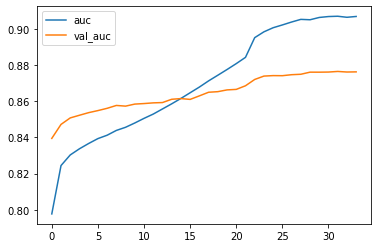

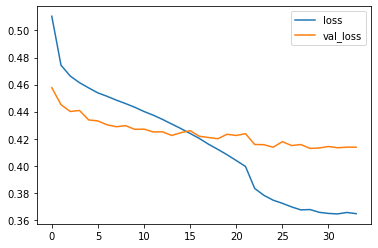

In [18]:
historyFrame = pd.DataFrame(history.history)
historyFrame[["auc", "val_auc"]].plot()
historyFrame[["loss", "val_loss"]].plot()
historyFrame.to_csv(f"{MDL_PATH}/history_mdl{Params['version']:03}.csv", index=False)

In [19]:
historyFrame

,loss,auc,val_loss,val_auc,lr
0,0.510482,0.797696,0.457714,0.839423,0.000100
1,0.474286,0.824413,0.445144,0.847146,0.000100
2,0.466298,0.830277,0.440120,0.850733,0.000100
3,0.461407,0.833681,0.440878,0.852206,0.000100
4,0.457529,0.836610,0.433870,0.853647,0.000100
5,0.453846,0.839307,0.433154,0.854775,0.000100
6,0.451325,0.841172,0.430236,0.856034,0.000100
7,0.448495,0.843819,0.428862,0.857617,0.000100
8,0.445970,0.845556,0.429647,0.857242,0.000100
9,0.443222,0.847931,0.426920,0.858368,0.000100


In [20]:
best_epoch = historyFrame.val_auc.argmax()
best_loss = historyFrame.iloc[best_epoch].loss
best_auc = historyFrame.iloc[best_epoch].val_auc
print("best epoch:", best_epoch,
      "| best loss:", best_loss,
      "| best auc:", best_auc
     )

best epoch: 31 | best loss: 0.3644496500492096 | best auc: 0.8764021396636963


In [21]:
result = Params.copy()
result["bavg_epoch"] = int(best_epoch)
result["bavg_loss"] = float(best_loss)
result["bavg_auc"] = float(best_auc)
with open(f"{MDL_PATH}/params.json", "w") as file:
    json.dump(result, file)

if not os.path.exists(f"{MDLS_PATH}/results.csv"):
    df_save = pd.DataFrame(result, index=[0])
    df_save.to_csv(f"{MDLS_PATH}/results.csv")
else:
    df_old = pd.read_csv(f"{MDLS_PATH}/results.csv", index_col=0)
    df_save = pd.DataFrame(result, index = [df_old.index.max() + 1])
    df_save = df_old.append(df_save, ignore_index=True)
    df_save.to_csv(f"{MDLS_PATH}/results.csv")   

In [22]:
pd.read_csv(f"{MDLS_PATH}/results.csv",index_col=[0])

,lr,version,train_mode,batch_size,epochs,bavg_epoch,bavg_loss,bavg_auc,changelog,seed
0,0.00100,1,full,256,60,16,0.451789,0.838065,NaN,NaN
1,0.00100,2,test,256,60,13,0.449180,0.822957,moved all relu layers before the pooling layers,NaN
2,0.00100,3,full,256,60,20,0.442866,0.837724,"tried on large ds, since hight overfitting",NaN
3,0.00100,5,test,256,60,13,0.449431,0.822973,added second layer to first block or reference,NaN
4,0.00100,6,test,256,30,9,0.442229,0.820143,added relu activations to all conv layers,NaN
5,0.00100,9,test,256,30,4,0.480765,0.812309,set all pool sizes to 1,NaN
6,0.00100,11,test,256,30,8,0.438630,0.819107,set all pool sizes to 8,NaN
7,0.00100,13,test,256,30,12,0.448575,0.820421,added second layer to first block with small k...,NaN
8,0.00010,14,test,256,30,12,0.457616,0.820876,added second layer to first block with small k...,NaN
9,0.00010,17,test,64,30,6,0.475783,0.814108,trial of completely different achitecture,NaN


In [22]:
if KAGGLE:
    te_files = tf.io.gfile.glob(f"{TRAIN_FILES_PATH}/test_*.tfrec")
else:
    te_files = glob(f"{TRAIN_FILES_PATH}/test_*.tfrec")
    te_files = glob(f"../input/filtered_tfrec/test_*.tfrec")
test_set = load_dataset(te_files, shuffle=False, ordered=True, labeled=False, repeat=False)
test_set

<PrefetchDataset shapes: ((None, 4096, 3), (None, 4096, 3)), types: (tf.float32, tf.float32)>

In [23]:
tf.keras.backend.clear_session()
with strategy.scope():
    model = tf.keras.models.load_model(f"{MDL_PATH}/model_{Params['version']:03}.h5")

In [24]:
prediction = model.predict(test_set)

In [25]:
prediction

array([[1.        ],
       [0.5228113 ],
       [0.16105618],
       ...,
       [0.31426096],
       [1.        ],
       [0.10687688]], dtype=float32)

In [26]:
sub = pd.read_csv("../input/g2net-gravitational-wave-detection/sample_submission.csv")
sub.head()

,id,target
0,00005bced6,0.5
1,0000806717,0.5
2,0000ef4fe1,0.5
3,00020de251,0.5
4,00024887b5,0.5


In [27]:
import gc
gc.collect()
sub.target = prediction

In [28]:
sub.to_csv(f"{MDL_PATH}/submission.csv", index = False)

In [29]:
from sklearn.metrics import roc_auc_score
tr_files = glob(f"{TRAIN_FILES_PATH}/train_*")
train_set = load_dataset(tr_files, shuffle=False, ordered=True, labeled=False, repeat=False)
pred_tr = model.predict(train_set)

KeyboardInterrupt: 

In [ ]:
tr_files

In [ ]:
pred_tr

In [ ]:
train_df = pd.read_csv(f"{INPUT_DIR}/training_labels.csv")
train_df.head()

In [ ]:
roc_auc_score(train_df.target, pred_tr)
test_y = np.load(f"{INPUT_DIR}/train_x.npy")

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
results = model.predict(test_y, batch_size = 100000)

In [ ]:
results